<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/PHYS152_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Classifying of Supersymmetric (SUSY) and Standard Model Particles


**Introduction and Overview:**

The Large Hadron Collider (LHC) is a particle accelerator which enables high-energy particle beams to collide at nearly the speed of light. The introduction of the LHC allowed for the discovery of the Higgs boson, which proved theoretical models beyond the Standard Model. Supersymmetric (SUSY) is a proposed extension of the Standard Model, and predicts the existance of superpartner particles, where every particle in the Standard Model has a partner particle with a different spin.

However, distinguishing between SM and SUSY events in LHC collision data is a challenging classication problem due to the complex and overlapping features in the data. The goal of this project is to use a neural network classifier for binary classification and an autoencoder for anomaly detection. At the end of the project, the ROC curve and confusion matrix will measure the effectiveness in classifying between the two particles classes.


This project will utilize the [Supersymmetry (SUSY) Dataset](https://www.kaggle.com/datasets/janus137/supersymmetry-dataset) from Kaggle, and consists of LHC collision events with labeled SM and SUSY particles.

**Data Loading & Exploration:**

The first step is to download the data and to assign columns that indicate whether a particle is Supersymmetric (SUSY) or Standard Model (SM). The dataset is then split into features (X) and labels (y). Finally, the features are scaled to ensure consistent input ranges and visaled through histograms to observe the distributions of each feature.

100%|██████████| 762M/762M [00:14<00:00, 54.9MB/s]

Extracting files...


   label  lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0    0.0   0.707258    0.613159   -0.763354                  1.010814   
1    0.0   0.493745   -1.745581   -0.640968                  0.576161   
2    1.0   1.305413    0.283820   -1.149154                  0.507217   
3    1.0   0.809715   -0.358303   -0.497172                  0.787675   
4    0.0   0.912852    1.797455   -1.360165                  0.496723   

   missing_energy_phi   jet1_pT  jet1_eta  jet1_phi   jet2_pT  jet2_eta  \
0            1.672101  1.544314  0.342641  0.286944  0.514347 -0.008000   
1           -0.514477 -0.629788  0.585841  0.874038  0.879419 -0.221701   
2           -0.194161  1.313993  0.659832  0.619593  0.534922 -0.320298   
3            0.027419  1.201305  0.790556 -0.861923  0.740287  0.890525   
4            1.199644  0.627462  1.206452 -1.362983  0.033791  1.509121   

   jet2_phi   jet3_pT  jet3_eta  jet3_phi   jet4_pT  jet4_eta  jet4_phi  \
0  0.832800  0.646217  0.688581  1.

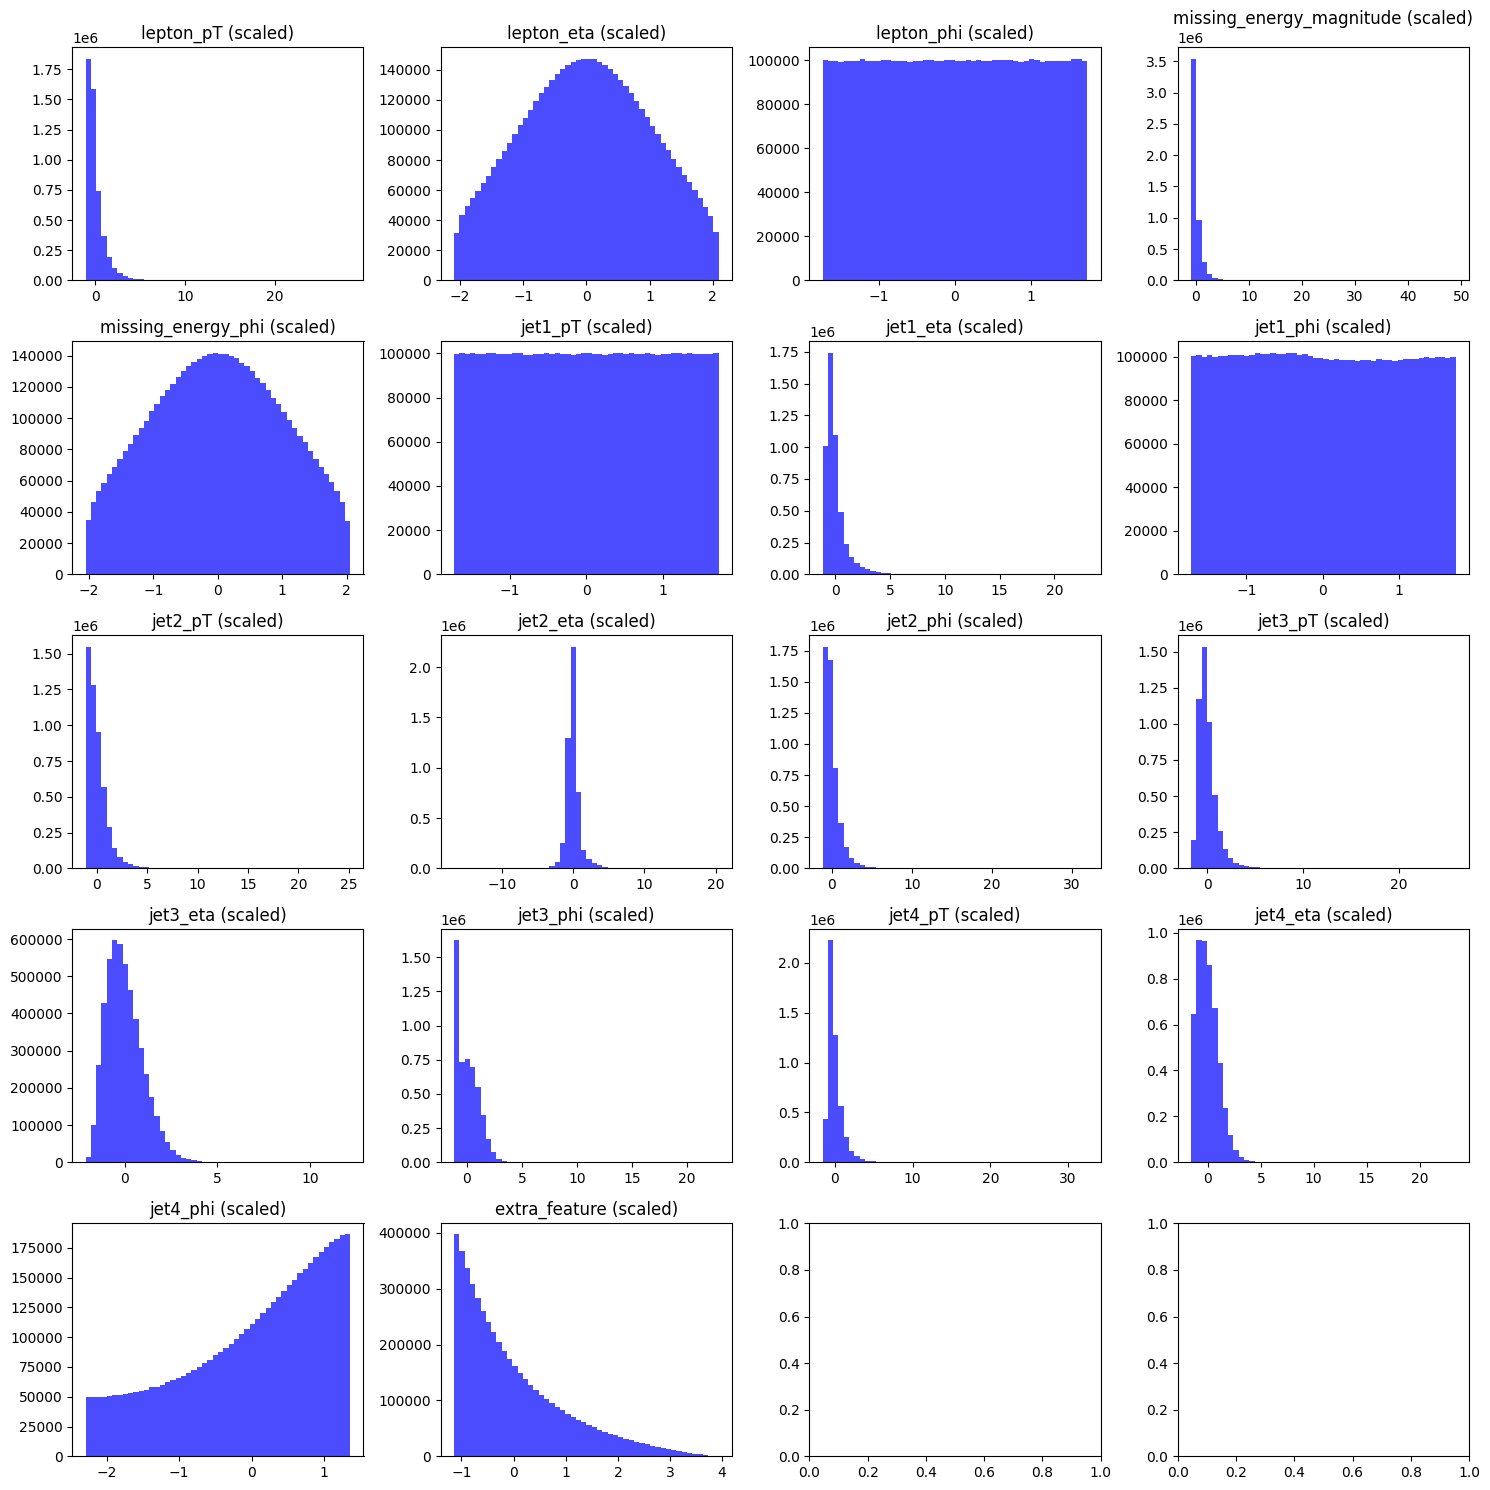

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub

#Downloading the latest version of the dataset
path = kagglehub.dataset_download("janus137/supersymmetry-dataset")
dataset_path = "/root/.cache/kagglehub/datasets/janus137/supersymmetry-dataset/versions/1/supersymmetry_dataset.csv"

data = pd.read_csv(dataset_path, header=0)

#Assigning columns
data.columns = [
    'label',
    'lepton_pT', 'lepton_eta', 'lepton_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet1_pT', 'jet1_eta', 'jet1_phi',
    'jet2_pT', 'jet2_eta', 'jet2_phi',
    'jet3_pT', 'jet3_eta', 'jet3_phi',
    'jet4_pT', 'jet4_eta', 'jet4_phi',
    'extra_feature'
]

print(data.head())
print(data.describe())
print(data.info())

#Define features (X) and labels (y)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

#Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

#Visualizing the distributions of all scaled features
fig, axs = plt.subplots(5, 4, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(X_train_scaled_df.columns):
    axs[i].hist(X_train_scaled_df[col], bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'{col} (scaled)')

plt.tight_layout()
plt.show()

**Interpretation:**

The dataset contains *5 million* entries, with 19 columns representing various particle features and the corresponding label, labeling a SUSY particle with a (1) and a SM particle with a (0).

**Information about the key features:**

lepton_pT, lepton_eta, and lepton_phi: Leptons are elementary particles with half-integer spin. pT represents the transverse momentum of the lepton (perpendicular to the beam axis), while eta is its pseudorapidity (describing the angle relative to the beam), and phi refers to the lepton's azimuthal angle.

missing_energy_magnitude and missing_energy_phi: These features correspond to the magnitude and direction of missing transverse energy, which is energy that cannot be accounted for by detected particles in the collision.

jet1_pT, jet2_pT, jet3_pT, jet4_pT: Jets are streams of particles produced when quarks or gluons are scattered. pT measures the transverse momentum, while eta indicates the pseudorapidity.

jet1_eta, jet2_eta, jet3_eta, jet4_eta: Please reference the definitions for jets and eta above.

extra_feature: This column is used for any additional characteristic that differs from the other labels.

The distribution of values for these features reveal key important aspects. For instance, lepton_pT has a broad range of values, with a mean around 1 GeV and a maximum reaching up to 20 GeV. Similarly, jet transverse momenta (e.g., jet1_pT) follow a similar distribution with a mean near 1 GeV, but some entries contain extreme values that likely correspond to high-energy events.

**Binary Classifier:**

The next step is to implement the binary classifier model, which tests different learning rates (0.02, 0.05, and 0.1) over 10 epochs. The model consists of three fully connected layers with LeakyReLU activation functions in-between, followed by a sigmoid activation function to produce predictions between 0 and 1. The Adam optimizer and binary cross-entropy loss function were used for training. The loss values for both the training and test sets were recorded and plotted to evaluate the model's performance across the different learning rates.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle

#Define model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

#Convert data to tensors
x_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
xy_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(X_train) / 5), shuffle=True)

#Dictionaries to store losses
train_losses_dict = {}
test_losses_dict = {}

#Training loop for different learning rates
for lr in [0.02, 0.05, 0.1]:
    print(f"Learning Rate: {lr}")

    #Initialize model, loss function, and optimizer
    input_dim = X_train.shape[1]
    net = BinaryClassifier(input_dim)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net.train()
    train_losses = []
    test_losses = []

    for epoch in range(10):
        start_time = time.time()

        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        net.eval()
        with torch.no_grad():
            y_pred_test = net(x_test_tensor)
            test_loss = loss_fn(y_pred_test, y_test_tensor)
            test_losses.append(test_loss.item())

        end_time = time.time()
        print(f"Epoch {epoch+1:2d} | Time: {end_time - start_time:.1f}s | Train Loss: {loss.item():.1e} | Test Loss: {test_loss.item():.1e}")

    train_losses_dict[lr] = train_losses
    test_losses_dict[lr] = test_losses

with open("loss_data.pkl", "wb") as f:
    pickle.dump({"train": train_losses_dict, "test": test_losses_dict}, f)

print("Loss values saved to loss_data.pkl")
torch.save(net.state_dict(), "binary_classifier.pth")

Learning Rate: 0.02
Epoch  1 | Time: 80.8s | Train Loss: 6.0e-01 | Test Loss: 5.7e-01
Epoch  2 | Time: 80.6s | Train Loss: 4.9e-01 | Test Loss: 4.8e-01
Epoch  3 | Time: 79.9s | Train Loss: 4.8e-01 | Test Loss: 4.7e-01
Epoch  4 | Time: 79.5s | Train Loss: 4.7e-01 | Test Loss: 4.6e-01
Epoch  5 | Time: 81.9s | Train Loss: 4.6e-01 | Test Loss: 4.5e-01
Epoch  6 | Time: 81.9s | Train Loss: 4.6e-01 | Test Loss: 4.5e-01
Epoch  7 | Time: 79.8s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  8 | Time: 80.5s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  9 | Time: 80.2s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Epoch 10 | Time: 81.2s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Learning Rate: 0.05
Epoch  1 | Time: 81.2s | Train Loss: 5.4e-01 | Test Loss: 5.0e-01
Epoch  2 | Time: 80.7s | Train Loss: 5.8e-01 | Test Loss: 5.5e-01
Epoch  3 | Time: 85.0s | Train Loss: 4.9e-01 | Test Loss: 4.7e-01
Epoch  4 | Time: 82.4s | Train Loss: 4.8e-01 | Test Loss: 4.7e-01
Epoch  5 | Time: 82.0s | Train Loss:

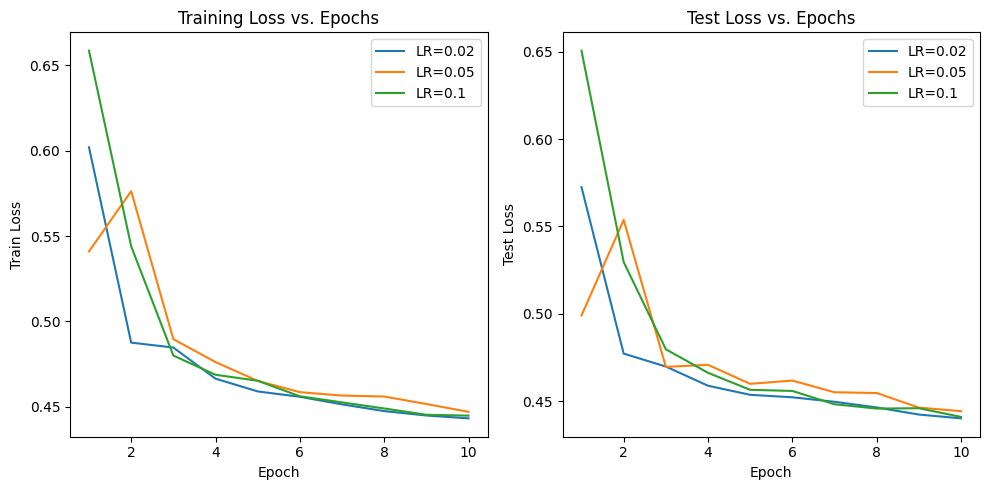

AUC: 0.87


In [15]:
import pickle
import matplotlib.pyplot as plt

with open("loss_data.pkl", "rb") as f:
    loss_data = pickle.load(f)

train_losses_dict = loss_data["train"]
test_losses_dict = loss_data["test"]

plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
for lr, losses in train_losses_dict.items():
    plt.plot(range(1, 11), losses, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

# Plot Test Loss
plt.subplot(1, 2, 2)
for lr, losses_test in test_losses_dict.items():
    plt.plot(range(1, 11), losses_test, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()

**Interpretation:**

The training loss consistently decreases over time for all learning rates, with the learning rate of 0.02 showing the most gradual and stable improvement. In contrast, learning rates of 0.05 and 0.1 show less stable behavior but ultimately converge to a test loss of around 0.44 by the 10th epoch. While all learning rates perform similarly, the learning rate of 0.02 has a smoother and more consistent learning process.

**ROC Curve:**

The next step is to use a ROC curve to plot the True Positive (TPR) against the False Positive Rate (FPR) to get an understanding of how it is performing compared to a random classifier.

<ipython-input-16-5e22f541696f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("binary_classifier.pth"))


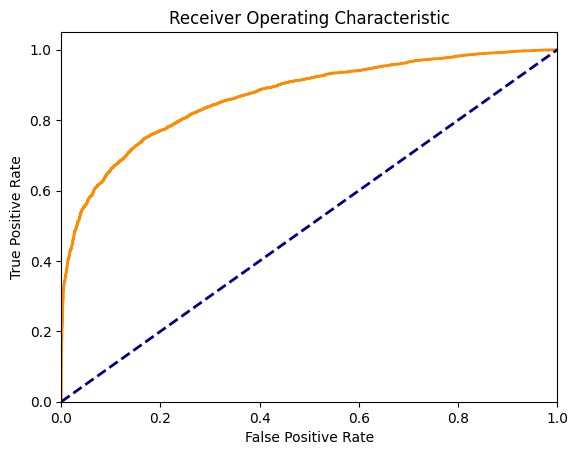

AUC: 0.87


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the trained model
net.load_state_dict(torch.load("binary_classifier.pth"))
net.eval()
with torch.no_grad():
    y_pred_test = net(x_test_tensor)

y_pred_probs = y_pred_test

y_pred_probs = y_pred_probs.cpu().numpy()
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

print(f'AUC: {roc_auc:.2f}')

**Interpretation:**

The ROC curve shows a steady rise, indicating that the model is effectively distinguishing between positive and negative instances. The area under the curve (AUC) is 0.87, which suggests good model performance. AUC values closer to 1 indicate better model accuracy, with 0.87 demonstrating that the model performs significantly better than a random classifier.

**Confusion Matrix:**

The following step is to use a confusion matrix to further interpret the breakdown of the model's predictions. The output will represent the counts for True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives
(TP).

<ipython-input-21-9c2a0af41445>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("binary_classifier.pth"))


Accuracy: 0.7938
Precision: 0.8107


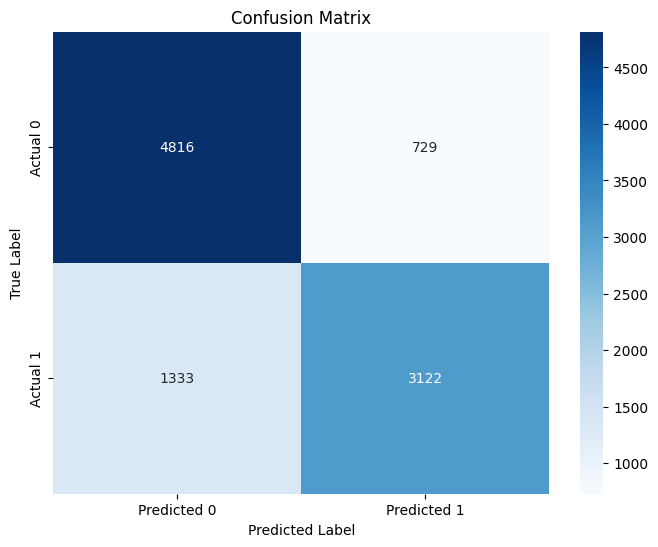

In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the trained model
net.load_state_dict(torch.load("binary_classifier.pth"))
net.eval()
with torch.no_grad():
    y_pred_test = net(x_test_tensor)

y_pred_probs = y_pred_test
y_pred_binary = (y_pred_probs > 0.5).float()

y_test_no = y_test_tensor.cpu().numpy()
y_pred_binary_np = y_pred_binary.cpu().numpy()

cm = confusion_matrix(y_test_no, y_pred_binary_np)

TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['Predicted 0', 'Predicted 1'],
            yticklabels = ['Actual 0', 'Actual 1']
            )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Interpretation:**

Let's breakdown each quadrant of the confusion matrix. As a reminder, 1 represents a SUSY particle and 0 represents a SM particle.

True Negatives (TN): 4816 (Predicted 0, Actual 0).

False Positives (FP): 729 (Predicted 1, Actual).

False Negatives (FN): 1333 (Predicted 0, Actual 1).

True Positives (TP): 3122 (Predicted 1, Actual 1).

The model has an accuracy of 0.7938, which means the model correctly predicted 79% of the test set. $\text{Accuracy: }\frac{TP + TN}{TP + TN + FP + FN}$

The model has a precision of 0.8107, which means 81% of the predicted positives were actually positive. $\text{Precision: }\frac{TP}{TP + FP}$

While the model seems to perform well overall, the high number of false negatives suggests that it could be improved further, especially in correctly identifying SUSY particles.






**Autoencoder for Feature Extraction:**

The final step is to use a Variational Autoencoder (VAE) for feature extraction. The VAE consists of an encoder that maps the input the data to a compressed latent space, and a decoder that reconstructs the original input from the lower-dimensional representation. The goal is to minimize the reconstruction error between the original input and the reconstructed output.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import pickle

# Adjusted loss function with mean reduction
def loss_function_MSE(x_hat, x, mu, logvar, β=0.1):
    MSE = nn.functional.mse_loss(x_hat, x, reduction='mean')  # Changed from 'sum' to 'mean'
    KLD = 0.5 * torch.mean(logvar.exp() - logvar - 1 + mu.pow(2))  # Mean instead of sum
    return MSE + β * KLD

#Define the VAE class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(VAE, self).__init__()

        #Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU()
        )

        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid() #Using sigmoid for output between 0 and 1 for scaled data
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

#Hyperparameters
learning_rate = 1e-3
epochs = 10
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Model setup
input_dim = X_train_scaled_df.shape[1]
model = VAE(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Convert data to tensors and create DataLoader
X_train_tensor = torch.tensor(X_train_scaled_df.values, dtype=torch.float32, device=device)  # Ensure it's on the correct device
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function_MSE(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1}: Average training loss: {train_loss / len(train_loader):.4f}')  # Adjusted normalization

Epoch 1: Average training loss: 0.7542
Epoch 2: Average training loss: 0.7313
Epoch 3: Average training loss: 0.7206
Epoch 4: Average training loss: 170.2390
Epoch 5: Average training loss: 162.8046
Epoch 6: Average training loss: 2.7064
Epoch 7: Average training loss: 0.7140
Epoch 8: Average training loss: 9048.8749
Epoch 9: Average training loss: 0.7101
Epoch 10: Average training loss: 0.7098


Visualizing the results:

Average Reconstruction Error (MSE): 1.3246


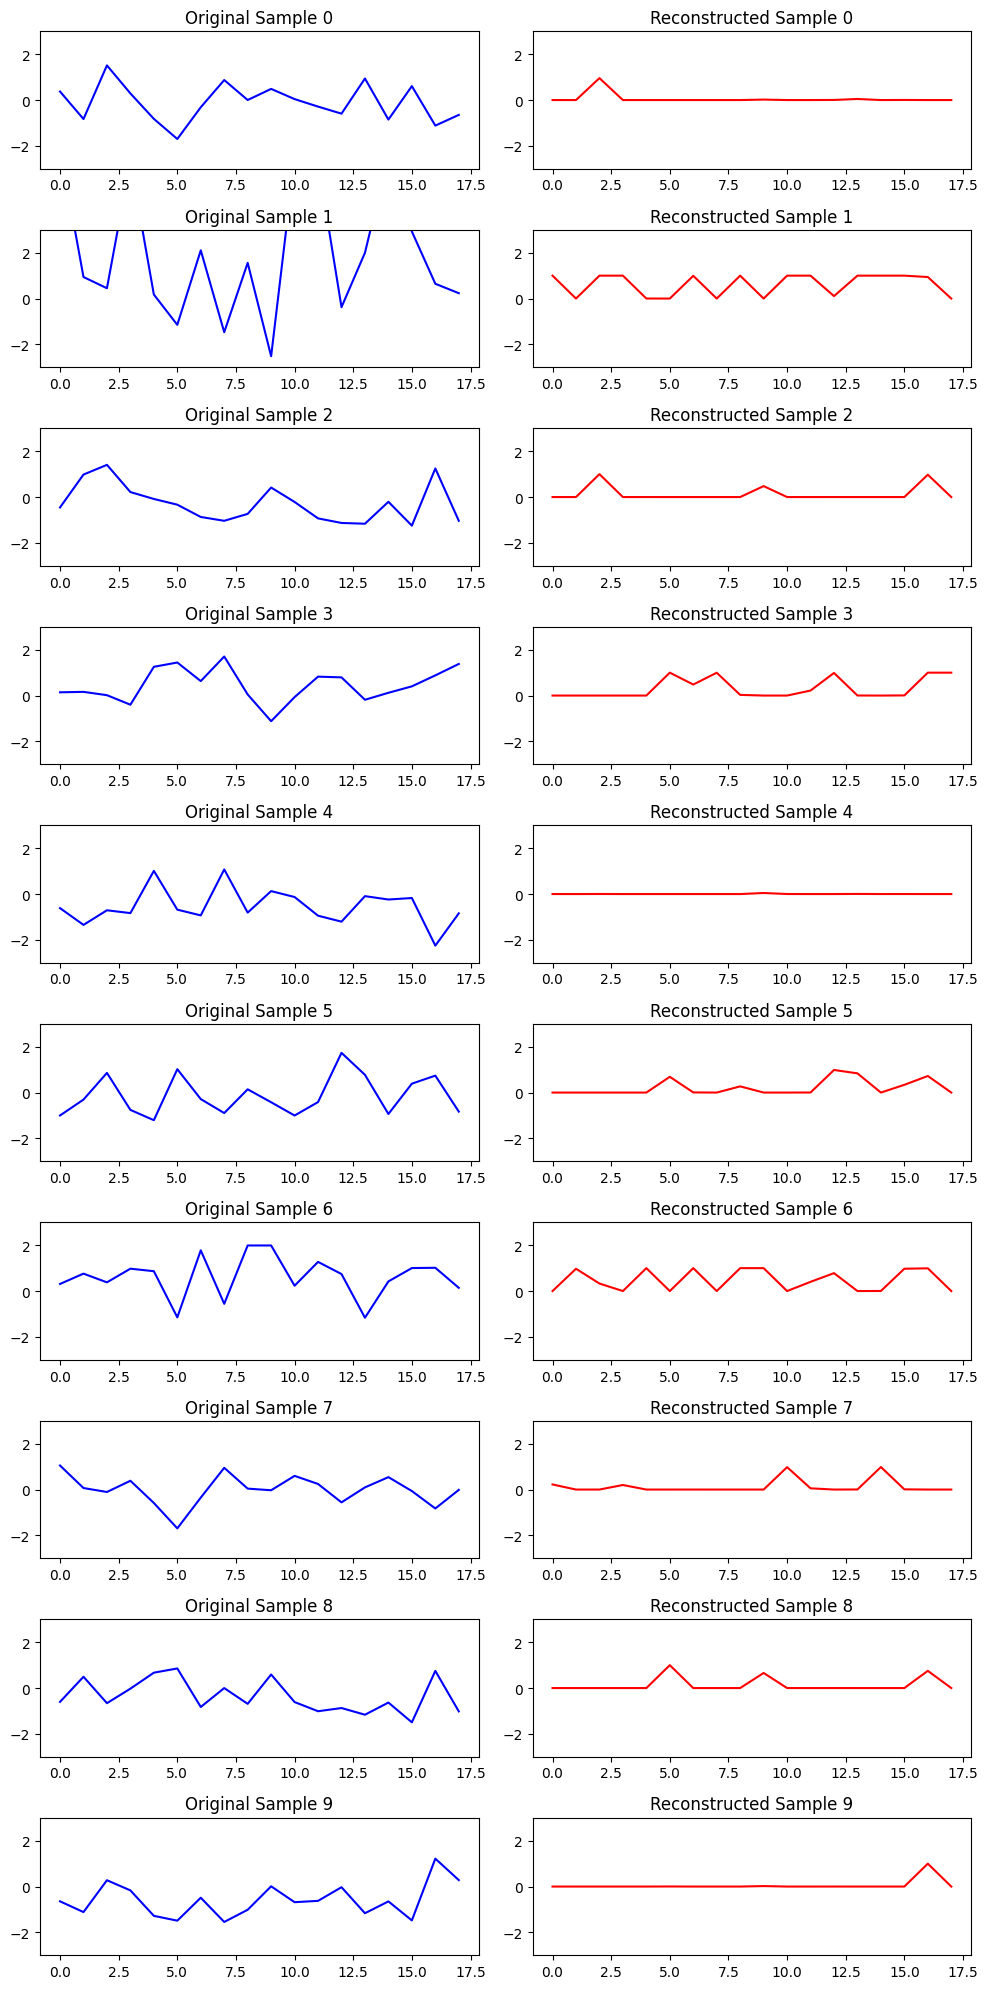

In [24]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 10
x_original = torch.tensor(X_test_scaled[:num_samples]).to(device).float()

#Pass through the VAE
with torch.no_grad():
    x_reconstructed, _, _ = model(x_original)

#Convert to NumPy for plotting
x_original = x_original.cpu().numpy()
x_reconstructed = x_reconstructed.cpu().numpy()

#Compute Mean Squared Error (MSE) for reconstruction
mse_values = np.mean((x_original - x_reconstructed) ** 2, axis=1)
average_mse = np.mean(mse_values)
print(f"Average Reconstruction Error (MSE): {average_mse:.4f}")

#Plot original vs reconstructed features
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

for i in range(num_samples):
    axes[i, 0].plot(x_original[i], label='Original', color='blue')
    axes[i, 0].set_title(f"Original Sample {i}")
    axes[i, 0].set_ylim([-3, 3])  # Adjust based on scaled data

    axes[i, 1].plot(x_reconstructed[i], label='Reconstructed', color='red')
    axes[i, 1].set_title(f"Reconstructed Sample {i}")
    axes[i, 1].set_ylim([-3, 3])

plt.tight_layout()
plt.show()


**Interpretation:**

From the high Mean Squared Error (MSE) value of 1.3246, the model does not accurately capture the underlying structure of the dataset. Despite this, some of the reconsructed samples, such as #1, #3, and #6 exhibit recognizable peaks and valleys from the original sample, albeit not accurately. The high MSE value could mean that the latent representation is not capturing enough information. One way to improve this value could be to adjust the hyperparameters, further increasing the latent space dimensionality, or modifying the network architecture.

**Conclusion:**

The goal of this project was to classify Supersymmetric (SUSY) particles from Standard Model (SM) particles using a binary classifyer and enhance feature extraction using a Variational Autoencoder (VAE). The classfier had an accuracy of 79.38%, but the high false negative rate suggests that there were limitations in distinguishing subtle differences. The autoencoder had a Mean Squared Error (MSE) of 1.3246, and struggled to fully reconstruct the input data, indicating that the latent space did not capture enough information. Potential improvements could include adjusting the hyperparameters, increasing the laten space dimensionality, or refining the network architecture.
